In [51]:
import pandas as pd
import numpy as np
TRAINING_X_FILE = '../../data/feature_vectors/external_x.npy'
TRAINING_Y_FILE = '../../data/feature_vectors/external_y.npy'

TESTING_X_FILE = '../../data/feature_vectors/backup/train_x_sliding_chunks.npy'
TESTING_Y_FILE = '../../data/feature_vectors/backup/train_y_sliding_chunks.npy'

X_train = np.load(TRAINING_X_FILE)[:5000]
y_train = np.load(TRAINING_Y_FILE)[:5000]

X_test = np.load(TESTING_X_FILE)
y_test = np.load(TESTING_Y_FILE)

In [52]:
X_train = np.concatenate((X_train, X_test[:1500]))
X_train.shape

(6500, 10, 171)

In [53]:
y_test.shape

(2980,)

In [54]:
y_train = np.concatenate((y_train, y_test[:1500]))
y_train.shape

(6500,)

In [55]:
X_test = X_test[1500:]
y_test = y_test[1500:]

In [56]:
print(X_train.shape, y_train.shape)

(6500, 10, 171) (6500,)


In [57]:
print(X_test.shape, y_test.shape)

(1480, 10, 171) (1480,)


In [58]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.layers import Bidirectional, TimeDistributed, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam, SGD
# fix random seed for reproducibility
numpy.random.seed(7)

In [59]:
def get_callbacks():    
    early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')
    
    return [early_stopping]

In [60]:
epochs = 15
batch_size = 64
input_shape = (X_train.shape[1], X_train.shape[2])

In [61]:
def get_model():
    model = Sequential()
    model.add(LSTM(256, dropout=0.5, return_sequences = True, input_shape=input_shape))
    model.add(LSTM(256, dropout=0.5, return_sequences = False))
    
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    sgd = SGD(lr=0.01, momentum=0.01, decay=0.0001, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [67]:
def get_model_pooling():
    model = Sequential()
    model.add(LSTM(256, dropout=0.2, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(256, dropout=0.2, return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [68]:
model = get_model_pooling()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 256)           438272    
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
global_average_pooling1d_12  (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 963,841
Trainable params: 963,841
Non-trainable params: 0
_________________________________________________________________


In [69]:
model = get_model_pooling()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 6500 samples, validate on 1480 samples
Epoch 1/15
6500/6500 [==============================] - 23s 4ms/step - loss: 0.6592 - acc: 0.6114 - val_loss: 0.6785 - val_acc: 0.6203
Epoch 2/15
6500/6500 [==============================] - 15s 2ms/step - loss: 0.6296 - acc: 0.6509 - val_loss: 0.6708 - val_acc: 0.5689
Epoch 3/15
6500/6500 [==============================] - 13s 2ms/step - loss: 0.6199 - acc: 0.6549 - val_loss: 0.6627 - val_acc: 0.6378
Epoch 4/15
6500/6500 [==============================] - 11s 2ms/step - loss: 0.6129 - acc: 0.6648 - val_loss: 0.6578 - val_acc: 0.6365
Epoch 5/15
6500/6500 [==============================] - 12s 2ms/step - loss: 0.6079 - acc: 0.6695 - val_loss: 0.6491 - val_acc: 0.6351
Epoch 6/15
6500/6500 [==============================] - 11s 2ms/step - loss: 0.5958 - acc: 0.6858 - val_loss: 0.6496 - val_acc: 0.6223
Epoch 7/15
6500/6500 [==============================] - 12s 2ms/step - loss: 0.5961 - acc: 0.6802 - val_loss: 0.6464 - val_acc: 0.6541
Epoch 8

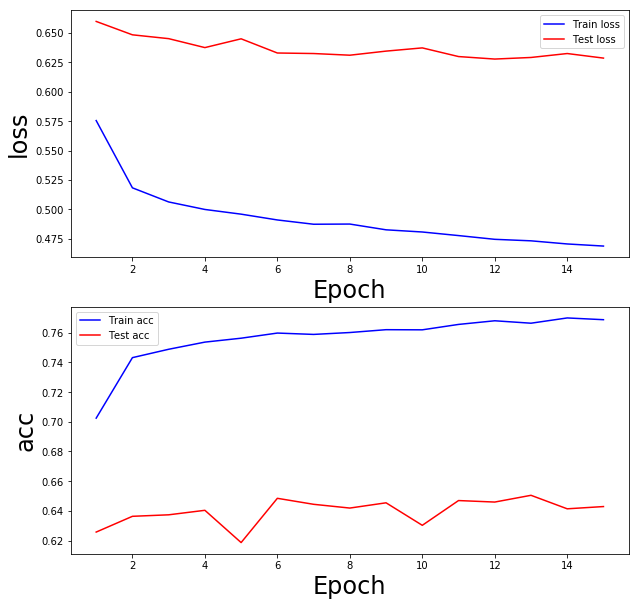

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))

def plot_history(ax, history, metric):
    rng = list(range(1, epochs + 1))
    m, = ax.plot(rng, history[metric], 'b', label='Train ' + metric)
    val_m, = ax.plot(rng, history['val_' + metric], 'r', label='Test ' + metric)
    ax.legend(handles=[m, val_m])
  
  
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel(metric, fontsize=24)  

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

plot_history(ax1, history.history, 'loss')
plot_history(ax2, history.history, 'acc')

In [42]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
cvscores = []
X=np.concatenate((X_train, X_test))
y=np.concatenate((y_train, y_test))
print(X.shape, y.shape)
for train, test in kfold.split(X_test, y_test):
  # create model
    model = model = get_model()
    # Fit the model
    model.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

(12980, 10, 171) (12980,)
Epoch 1/15
1485/1485 [==============================] - 5s 4ms/step - loss: 0.6540 - acc: 0.6101
Epoch 2/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.6081 - acc: 0.6754
Epoch 3/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5970 - acc: 0.6889
Epoch 4/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5902 - acc: 0.7017
Epoch 5/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5882 - acc: 0.6929
Epoch 6/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5621 - acc: 0.7266
Epoch 7/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5745 - acc: 0.7037
Epoch 8/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5617 - acc: 0.7185
Epoch 9/15
1485/1485 [==============================] - 2s 2ms/step - loss: 0.5579 - acc: 0.7253
Epoch 10/15
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5493 - acc: 0.7178
Epo

In [70]:
np.array([1, 2, 3]).reshape(-1, 1)

array([[1],
       [2],
       [3]])